### Imports

In [723]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [724]:
import pandas as pd 
import os 
import yaml
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [725]:

from qbt.strategies.strategy_registry import create_strategy, available_strategies



In [726]:
style_path = os.path.join(os.getcwd(), 'styler.mplstyle')
plt.style.use(style_path)

### Main Configs

In [727]:

INTRADAY_FREQ="10min"   # 5 Min, 10 Min, 15 Min
CUTOFF="16:00"      # 3pm, 3:30PM, or 4PM
SELECTION_YEARS=2   # 1, 2, 3 
GRID_SIZE=50      # 20, 50, 100
RF="0%"             # or "1m", "3m"
EXEC_TIMING="close_to_close"  # or "open_to_close"


### Step 1: Construct State Variable

load data

In [728]:
path = os.path.join(os.getcwd(), '..', 'data', 'silver', 'freq=5Min', 'ticker=XLE', 'bars.parquet')
df = pd.read_parquet(path)
df.set_index('timestamp', inplace=True)

functions to handle rv computation logic

In [729]:
def resample_ohlcv(
    df: pd.DataFrame,
    *,
    rv_freq: str = "10min",
    tz: str | None = "America/New_York",
    session_start: str = "09:30",
    session_end: str = "16:00",
    open_col: str = "open",
    high_col: str = "high",
    low_col: str = "low",
    close_col: str = "close",
    volume_col: str = "volume",
) -> pd.DataFrame:
    x = df.copy()
    if not isinstance(x.index, pd.DatetimeIndex):
        raise ValueError("df must be indexed by a DatetimeIndex.")
    x = x.sort_index()

    tz = tz or "America/New_York"   # <-- key fix

    if x.index.tz is None:
        x.index = x.index.tz_localize(tz)
    else:
        x.index = x.index.tz_convert(tz)

    if session_start and session_end:
        x = x.between_time(session_start, session_end, inclusive="both")

    needed = [open_col, high_col, low_col, close_col]
    missing = [c for c in needed if c not in x.columns]
    if missing:
        raise ValueError(f"Missing required columns: {missing}")

    agg_map = {open_col: "first", high_col: "max", low_col: "min", close_col: "last"}
    if volume_col in x.columns:
        agg_map[volume_col] = "sum"

    out = x.resample(rv_freq).agg(agg_map)
    out = out.dropna(subset=[open_col, high_col, low_col, close_col], how="all")
    return out




def rv_open_to_cutoff(
    intraday: pd.DataFrame,
    *,
    price_col: str = "close",
    cutoff_time: str = "15:00",
    min_obs: int = 10,
) -> pd.Series:
    
    ret = np.log(intraday[price_col]).diff().dropna()

    # keep only returns with timestamp <= cutoff within each calendar day
    h, m = map(int, cutoff_time.split(":"))
    cutoff_delta = pd.Timedelta(hours=h, minutes=m)
    intraday_offset = ret.index - ret.index.normalize()
    ret = ret[intraday_offset <= cutoff_delta]

    # group by calendar day and sum squared returns
    day = ret.index.normalize()
    rv = ret.pow(2).groupby(day).sum(min_count=1)
    rv = np.sqrt(rv)
    n = ret.groupby(day).count()
    rv[n < min_obs] = np.nan

    rv.name = "rvol_open_to_cutoff"
    return rv



def rv_cutoff_to_cutoff(
    intraday: pd.DataFrame,
    *,
    price_col: str = "close",
    cutoff_time: str = "15:00",
    min_obs: int = 10,
) -> pd.Series:

    ret = np.log(intraday[price_col]).diff().dropna()
    # bucket by cutoff-defined day:
    # shift forward so that cutoff aligns with midnight, then normalize
    h, m = map(int, cutoff_time.split(":"))
    cutoff_delta = pd.Timedelta(hours=h, minutes=m)
    shift = pd.Timedelta(days=1) - cutoff_delta
    cutoff_day = (ret.index + shift).normalize()

    rv = ret.pow(2).groupby(cutoff_day).sum(min_count=1)
    rv = np.sqrt(rv)
    n = ret.groupby(cutoff_day).count()
    rv[n < min_obs] = np.nan

    rv.name = "rvol_cutoff_to_cutoff"
    return rv


def compute_state_variable(
    df: pd.DataFrame,
    *,
    rv_freq: str = "10min",
    cutoff_time: str = "16:00",
    tz: str | None = "America/New_York",
) -> pd.DataFrame:
    tz = tz or "America/New_York"

    # 1) Intraday resample for RV computations
    intraday = resample_ohlcv(df, rv_freq=rv_freq, tz=tz)

    # 2) RV computations (daily-indexed Series)
    rv_c2c = rv_cutoff_to_cutoff(intraday, cutoff_time=cutoff_time).rename("rvol_c2c")
    rv_o2c = rv_open_to_cutoff(intraday, cutoff_time=cutoff_time).rename("rvol_o2c")

    # 3) Daily OHLCV for returns (RTH)
    daily = resample_ohlcv(df, rv_freq="1D", tz=tz)

    # log returns on daily bars
    daily["ret_cc"] = np.log(daily["close"]).diff()
    daily["ret_oc"] = np.log(daily["close"] / daily["open"])

    # 4) Merge RV into daily (index alignment by date)
    out = daily.join(rv_c2c, how="left").join(rv_o2c, how="left").sort_index()

    # 5) Add explicit “next-day return” columns for t -> t+1 alignment for trading
    out["ret_cc_next"] = out["ret_cc"].shift(-1)
    out["ret_oc_next"] = out["ret_oc"].shift(-1)
    
    return out

In [730]:

df = compute_state_variable(df)

add risk free rate

In [731]:
path = os.path.join(os.getcwd(), '..', 'data', 'silver', 'freq=1d', 'ticker=TB3MS', 'bars.parquet')
rf_3m = pd.read_parquet(path).set_index('datetime').tz_convert('America/New_York')
rf_3m = rf_3m.rename(columns={'close': 'TBILL-3M'})

In [732]:
path = os.path.join(os.getcwd(), '..', 'data', 'silver', 'freq=1d', 'ticker=DTB4WK', 'bars.parquet')
rf_1m = pd.read_parquet(path).set_index('datetime').tz_convert('America/New_York')
rf_1m = rf_1m.rename(columns={'close': 'TBILL-1M'})

In [733]:
df_day = df.copy()
rf_1m_day = rf_1m.copy()
rf_3m_day = rf_3m.copy()

df_day["date"] = df_day.index.normalize()
rf_1m_day["date"] = rf_1m_day.index.normalize()
rf_3m_day["date"] = rf_3m_day.index.normalize()

df = (
    df_day
    .merge(rf_1m_day[['date', 'TBILL-1M']], on="date", how="left", suffixes=("", "_rf1m"))
    .merge(rf_3m_day[['date', 'TBILL-3M']], on="date", how="left", suffixes=("", "_rf3m"))
    .rename(columns = {'date': 'datetime'})
    .set_index('datetime')
)

df['TBILL-1M'] /= 100
df['TBILL-3M'] /= 100

In [734]:
df

,open,high,low,close,volume,ret_cc,ret_oc,rvol_c2c,rvol_o2c,ret_cc_next,ret_oc_next,TBILL-1M,TBILL-3M
datetime,,,,,,,,,,,,,
2021-01-04 00:00:00-05:00,15.890,16.010,15.550,15.710,1006082,NaN,-0.011393,0.021171,0.021171,0.045420,0.034027,0.0008,0.0008
2021-01-05 00:00:00-05:00,15.890,16.860,15.890,16.440,1671622,0.045420,0.034027,0.030968,0.030968,0.029960,0.010086,0.0009,0.0008
2021-01-06 00:00:00-05:00,16.770,17.090,16.550,16.940,1118084,0.029960,0.010086,0.027443,0.027443,0.014068,0.009357,0.0009,0.0008
2021-01-07 00:00:00-05:00,17.020,17.350,16.920,17.180,767390,0.014068,0.009357,0.017849,0.017849,-0.000582,-0.011005,0.0008,0.0008
2021-01-08 00:00:00-05:00,17.360,17.390,17.040,17.170,719310,-0.000582,-0.011005,0.019700,0.019700,0.015603,0.037388,0.0008,0.0008
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-12-24 00:00:00-05:00,44.450,44.550,44.315,44.365,528280,-0.002814,-0.001914,0.005843,0.005843,-0.003613,-0.001921,NaN,0.0359
2025-12-26 00:00:00-05:00,44.290,44.430,43.995,44.205,1074621,-0.003613,-0.001921,0.004992,0.004992,0.009344,0.003030,0.0356,0.0359
2025-12-29 00:00:00-05:00,44.485,44.740,44.295,44.620,1678225,0.009344,0.003030,0.007349,0.007349,0.008036,0.003452,0.0350,0.0359


### Step 2: Split Dataset

In [735]:
def split_data(df: pd.DataFrame, years: int):
    """

    - Use last 5 years of data
    - First `years` years -> selection (Train)
    - Last 2 years -> evaluation (Test)

    Parameters
    ----------
    df : pd.DataFrame
        Must have a DatetimeIndex (daily frequency)
    years : int
        Number of years in selection sample (1, 2, or 3)

    Returns
    -------
    Train : pd.DataFrame
        Selection sample (used to estimate τ*)
    Test : pd.DataFrame
        Evaluation sample (used for trading)
    """
    if years not in {1, 2, 3}:
        raise ValueError("years must be one of {1, 2, 3}")

    if not isinstance(df.index, pd.DatetimeIndex):
        raise TypeError("df must have a DatetimeIndex")

    df = df.sort_index()

    # --- restrict to last 5 years ---
    end_date = df.index.max()
    start_5y = end_date - pd.DateOffset(years=5)

    df_5y = df.loc[start_5y:end_date]

    # --- define cutoffs ---
    test_start = end_date - pd.DateOffset(years=2)
    train_end = df.index.min() + pd.DateOffset(years=years)

    # --- split ---
    Train = df_5y.loc[:train_end]
    Test  = df_5y.loc[test_start:end_date]

    return Train, Test

In [736]:
Train, Test = split_data(df, years=SELECTION_YEARS)


In [737]:
Train

,open,high,low,close,volume,ret_cc,ret_oc,rvol_c2c,rvol_o2c,ret_cc_next,ret_oc_next,TBILL-1M,TBILL-3M
datetime,,,,,,,,,,,,,
2021-01-04 00:00:00-05:00,15.89,16.01,15.55,15.71,1006082,NaN,-0.011393,0.021171,0.021171,0.045420,0.034027,0.0008,0.0008
2021-01-05 00:00:00-05:00,15.89,16.86,15.89,16.44,1671622,0.045420,0.034027,0.030968,0.030968,0.029960,0.010086,0.0009,0.0008
2021-01-06 00:00:00-05:00,16.77,17.09,16.55,16.94,1118084,0.029960,0.010086,0.027443,0.027443,0.014068,0.009357,0.0009,0.0008
2021-01-07 00:00:00-05:00,17.02,17.35,16.92,17.18,767390,0.014068,0.009357,0.017849,0.017849,-0.000582,-0.011005,0.0008,0.0008
2021-01-08 00:00:00-05:00,17.36,17.39,17.04,17.17,719310,-0.000582,-0.011005,0.019700,0.019700,0.015603,0.037388,0.0008,0.0008
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-28 00:00:00-05:00,39.67,39.67,38.76,38.89,587462,-0.022878,-0.019858,0.015591,0.015591,0.009724,0.014105,0.0388,0.0425
2022-12-29 00:00:00-05:00,38.72,39.46,38.70,39.27,584710,0.009724,0.014105,0.010077,0.010077,0.006852,0.011446,0.0395,0.0425
2022-12-30 00:00:00-05:00,39.09,39.60,39.09,39.54,509874,0.006852,0.011446,0.011629,0.011629,-0.037099,-0.029737,0.0395,0.0425


In [738]:
Test

,open,high,low,close,volume,ret_cc,ret_oc,rvol_c2c,rvol_o2c,ret_cc_next,ret_oc_next,TBILL-1M,TBILL-3M
datetime,,,,,,,,,,,,,
2024-01-02 00:00:00-05:00,39.530,40.060,39.520,39.730,676502,0.011646,0.005047,0.012427,0.012427,0.014989,0.016248,0.0527,0.0522
2024-01-03 00:00:00-05:00,39.680,40.480,39.560,40.330,833186,0.014989,0.016248,0.009108,0.009108,-0.016752,-0.023917,0.0529,0.0522
2024-01-04 00:00:00-05:00,40.620,40.780,39.610,39.660,699678,-0.016752,-0.023917,0.010006,0.010006,0.000504,-0.006781,0.0528,0.0522
2024-01-05 00:00:00-05:00,39.950,40.010,39.500,39.680,490304,0.000504,-0.006781,0.010121,0.010121,-0.011406,0.006650,0.0528,0.0522
2024-01-08 00:00:00-05:00,38.970,39.260,38.460,39.230,885242,-0.011406,0.006650,0.026814,0.026814,-0.016967,-0.017222,0.0528,0.0522
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-12-24 00:00:00-05:00,44.450,44.550,44.315,44.365,528280,-0.002814,-0.001914,0.005843,0.005843,-0.003613,-0.001921,NaN,0.0359
2025-12-26 00:00:00-05:00,44.290,44.430,43.995,44.205,1074621,-0.003613,-0.001921,0.004992,0.004992,0.009344,0.003030,0.0356,0.0359
2025-12-29 00:00:00-05:00,44.485,44.740,44.295,44.620,1678225,0.009344,0.003030,0.007349,0.007349,0.008036,0.003452,0.0350,0.0359


### Step 3: Candidate Thresholds

In [739]:

def candidate_thresholds(state_var, n_grid, min_quintile=0):
    s = np.asarray(state_var)
    s = s[~np.isnan(s)]  # defensive: drop NaNs

    if s.size == 0:
        raise ValueError("state_var contains no valid observations")

    if min_quintile > 0:
        qs = np.linspace(min_quintile, 1.0 - min_quintile, n_grid)
    else:
        qs = np.linspace(0.0, 1.0, n_grid, endpoint=True)

    candidates = np.unique(np.quantile(s, qs))

    return candidates

### Step 4 : Regime Classification

In [740]:
def regime_classification(state_var, tau, df):
    mask = state_var <= tau
    low = df[mask]
    high = df[~mask]             
    
    return low, high

### Step 5 : Sharpe Ratios of Regime

In [741]:
def _sharpe(
    df: pd.DataFrame,
    ret_column: str,
    risk_free_rate: str = '0%',   # "0%", "TBILL-1M", "TBILL-3M"
    ann_factor: int = 252,
) -> float:
    """
    risk_free_rate:
        "0%"        -> no risk-free rate
        "1m"  -> use df["TBILL-1M"] (annualized % yield)
        "3m"  -> use df["TBILL-3M"] (annualized % yield)
    """

    ret = df[ret_column].dropna()

    # -----------------------
    # Select risk-free series
    # -----------------------
    if risk_free_rate == "0%" or risk_free_rate is None:
        rf_series = pd.Series(0.0, index=ret.index)

    elif risk_free_rate == "TBILL-1M":
        rf_series = df["TBILL-1M"]

    elif risk_free_rate == "TBILL-3M":
        rf_series = df["TBILL-3M"]

    else:
        raise ValueError(f"Unknown risk_free_rate: {risk_free_rate}")

    # -----------------------
    # Align by date
    # -----------------------
    ret, rf_series = ret.align(rf_series, join="inner")

    # -----------------------
    # Convert yield → per-period return
    # (FRED T-bills are in annualized %)
    # -----------------------
    rf_per_period = rf_series / 100.0 / ann_factor

    # -----------------------
    # Excess returns
    # -----------------------
    excess_ret = ret - rf_per_period

    mu = excess_ret.mean()
    sd = excess_ret.std(ddof=0)

    if sd <= 0 or np.isnan(sd):
        return np.nan

    sharpe = mu / sd * np.sqrt(ann_factor)
    return float(sharpe)

def sharpe_ratio_by_regime(low, high, ret_columns='ret_cc', risk_free_rate=0):
    
    sr_low = _sharpe(low, ret_column=ret_columns ,risk_free_rate=risk_free_rate, ann_factor=252)

    sr_high = _sharpe(high, ret_column=ret_columns ,risk_free_rate=risk_free_rate, ann_factor=252)

    return sr_low, sr_high


### Step 6: chose the threshold

In [742]:
def choose_threshold(df, n_grid, min_quintile=.10, risk_free_rate=0):
    results = []

    tau_star = None
    best_obj = -np.inf
    state_var_arr = df['rvol_o2c']

    candidates = candidate_thresholds(state_var_arr, n_grid, min_quintile)
    for tau in candidates:
        low, high = regime_classification(state_var_arr, tau, df)

        
        
        sr_low, sr_high = sharpe_ratio_by_regime(low, high, risk_free_rate=risk_free_rate)


        if np.isnan(sr_low) or np.isnan(sr_high):
            continue

        obj = sr_low - sr_high


        results.append({'tau': tau, 'sharpe_diff': obj, 'sharpe_low_state': sr_low, 'sharpe_high_state': sr_high, 'n_low': len(low), 'n_high': len(high)})


        if obj > best_obj:
            best_obj = obj
            tau_star = float(tau)


    return tau_star, pd.DataFrame(results)



In [743]:
tau_star, res = choose_threshold(Train, GRID_SIZE, min_quintile=0, risk_free_rate=RF)

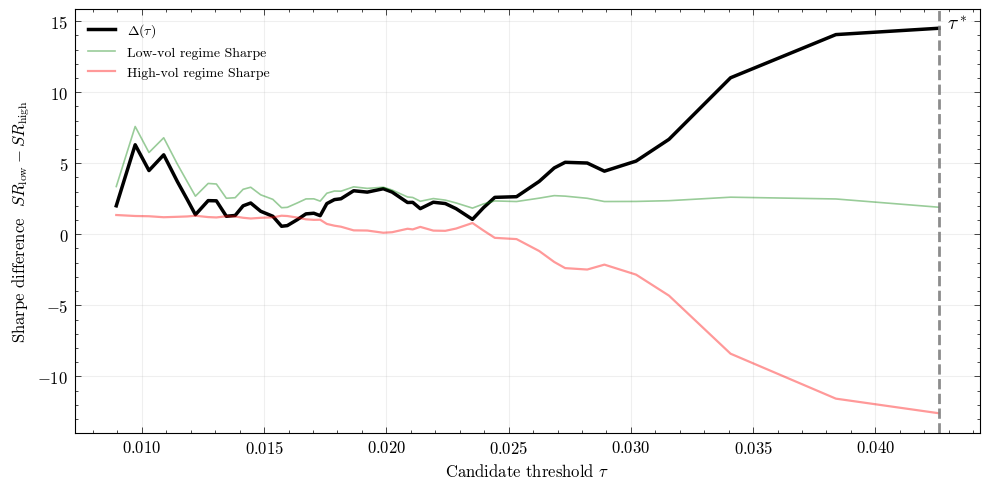

In [744]:
plt.figure(figsize=(10, 5))

# Main Sharpe difference
plt.plot(
    res["tau"],
    res["sharpe_diff"],
    label=r"$\Delta(\tau)$",
    linewidth=2.5,
    color="black"
)

# Regime Sharpes (low alpha, clear colors)
plt.plot(
    res["tau"],
    res["sharpe_low_state"],
    label="Low-vol regime Sharpe",
    color="green",
    alpha=0.4,
    linewidth=1.2
)

plt.plot(
    res["tau"],
    res["sharpe_high_state"],
    label="High-vol regime Sharpe",
    color="red",
    alpha=0.4,
    linewidth=1.6
)

# Tau star
plt.axvline(
    tau_star,
    linestyle="--",
    linewidth=2,
    color="grey",
    alpha=0.9
)

# Bold tau star annotation
x_offset = 0.01 * (res["tau"].max() - res["tau"].min())
ymax = plt.ylim()[1]

plt.text(
    tau_star + x_offset,
    ymax * 0.97,
    r"$\boldsymbol{\tau^*}$",
    ha="left",
    va="top",
    fontsize=14,
    fontweight="bold",
    color="black",
    bbox=dict(
        boxstyle="round,pad=0.2",
        facecolor="white",
        edgecolor="none",
        alpha=0.8
    )
)


# Labels
plt.xlabel(r"Candidate threshold $\tau$")
plt.ylabel(r"Sharpe difference  $SR_{\text{low}} - SR_{\text{high}}$")

# Legend
plt.legend(frameon=False)

# Clean look
plt.grid(alpha=0.2)
plt.tight_layout()


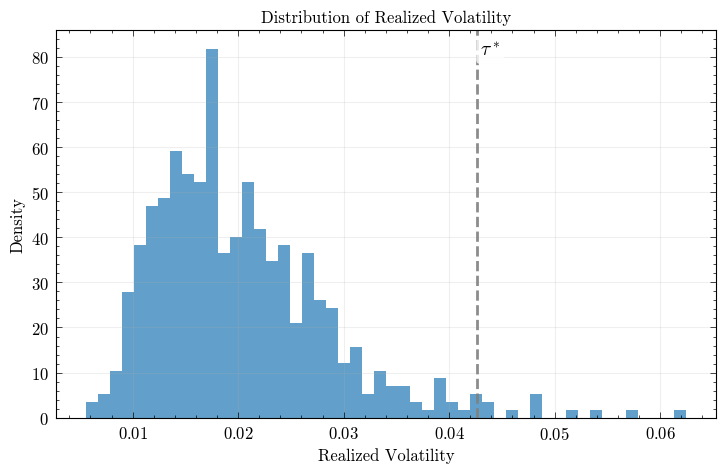

In [745]:
plt.figure(figsize=(8,5))

plt.hist(Train['rvol_o2c'], bins=50, density=True, alpha=0.7)

plt.axvline(
    tau_star,
    linestyle="--",
    linewidth=2,
    color="grey",
    alpha=0.9
)

# Bold tau star annotation
x_offset = 0.01 * (res["tau"].max() - res["tau"].min())
ymax = plt.ylim()[1]

plt.text(
    tau_star + x_offset,
    ymax * 0.97,
    r"$\boldsymbol{\tau^*}$",
    ha="left",
    va="top",
    fontsize=14,
    fontweight="bold",
    color="black",
    bbox=dict(
        boxstyle="round,pad=0.2",
        facecolor="white",
        edgecolor="none",
        alpha=0.8
    )
)


plt.xlabel("Realized Volatility")
plt.ylabel("Density")
plt.title("Distribution of Realized Volatility")

plt.grid(alpha=0.2)
plt.show()


### Step 7: Trading rule in evaluation sample

In [746]:
Test

,open,high,low,close,volume,ret_cc,ret_oc,rvol_c2c,rvol_o2c,ret_cc_next,ret_oc_next,TBILL-1M,TBILL-3M
datetime,,,,,,,,,,,,,
2024-01-02 00:00:00-05:00,39.530,40.060,39.520,39.730,676502,0.011646,0.005047,0.012427,0.012427,0.014989,0.016248,0.0527,0.0522
2024-01-03 00:00:00-05:00,39.680,40.480,39.560,40.330,833186,0.014989,0.016248,0.009108,0.009108,-0.016752,-0.023917,0.0529,0.0522
2024-01-04 00:00:00-05:00,40.620,40.780,39.610,39.660,699678,-0.016752,-0.023917,0.010006,0.010006,0.000504,-0.006781,0.0528,0.0522
2024-01-05 00:00:00-05:00,39.950,40.010,39.500,39.680,490304,0.000504,-0.006781,0.010121,0.010121,-0.011406,0.006650,0.0528,0.0522
2024-01-08 00:00:00-05:00,38.970,39.260,38.460,39.230,885242,-0.011406,0.006650,0.026814,0.026814,-0.016967,-0.017222,0.0528,0.0522
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-12-24 00:00:00-05:00,44.450,44.550,44.315,44.365,528280,-0.002814,-0.001914,0.005843,0.005843,-0.003613,-0.001921,NaN,0.0359
2025-12-26 00:00:00-05:00,44.290,44.430,43.995,44.205,1074621,-0.003613,-0.001921,0.004992,0.004992,0.009344,0.003030,0.0356,0.0359
2025-12-29 00:00:00-05:00,44.485,44.740,44.295,44.620,1678225,0.009344,0.003030,0.007349,0.007349,0.008036,0.003452,0.0350,0.0359


In [747]:

def estimate_performance(
    test: pd.DataFrame,
    *,
    tau: float,
    state_col: str = "rvol_o2c",
    ret_cc_next_col: str = "ret_cc_next",
    ret_o2c_next_col: str = "ret_oc_next",
) -> pd.DataFrame:
    x = test.copy().sort_index()


    x["signal_t"] = (x[state_col] < tau).astype(int)
    # multiply by precomputed returns
    x["strat_ret_c2c"] = x["signal_t"] * x[ret_cc_next_col]
    x["strat_ret_o2c"] = x["signal_t"] * x[ret_o2c_next_col]

    # keep rows where both returns exist
    out = x.dropna(subset=[ret_cc_next_col, ret_o2c_next_col]).copy()

    return out[[state_col, "signal_t", ret_cc_next_col, "strat_ret_c2c", ret_o2c_next_col, "strat_ret_o2c"]]





In [748]:
strat_returns = estimate_performance(Test, tau=tau_star)

In [749]:
strat_returns

,rvol_o2c,signal_t,ret_cc_next,strat_ret_c2c,ret_oc_next,strat_ret_o2c
datetime,,,,,,
2024-01-02 00:00:00-05:00,0.012427,1,0.014989,0.014989,0.016248,0.016248
2024-01-03 00:00:00-05:00,0.009108,1,-0.016752,-0.016752,-0.023917,-0.023917
2024-01-04 00:00:00-05:00,0.010006,1,0.000504,0.000504,-0.006781,-0.006781
2024-01-05 00:00:00-05:00,0.010121,1,-0.011406,-0.011406,0.006650,0.006650
2024-01-08 00:00:00-05:00,0.026814,1,-0.016967,-0.016967,-0.017222,-0.017222
...,...,...,...,...,...,...
2025-12-23 00:00:00-05:00,0.005684,1,-0.002814,-0.002814,-0.001914,-0.001914
2025-12-24 00:00:00-05:00,0.005843,1,-0.003613,-0.003613,-0.001921,-0.001921
2025-12-26 00:00:00-05:00,0.004992,1,0.009344,0.009344,0.003030,0.003030


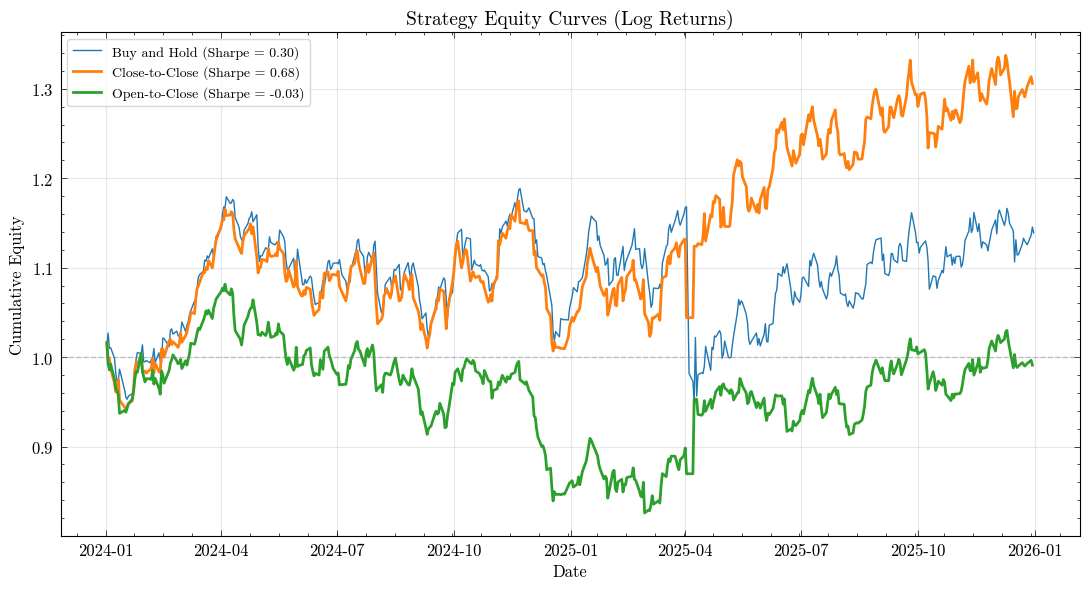

In [755]:
import numpy as np
import matplotlib.pyplot as plt

def sharpe_log(ret, ann_factor=252):
    r = ret.dropna()
    sd = r.std(ddof=0)
    if sd <= 0:
        return np.nan
    return r.mean() / sd * np.sqrt(ann_factor)


# --- equity curves from log returns ---
eq_c2c = np.exp(strat_returns["strat_ret_c2c"].fillna(0).cumsum())
eq_o2c = np.exp(strat_returns["strat_ret_o2c"].fillna(0).cumsum())
eq_bh = np.exp(Test['ret_cc'].fillna(0).cumsum())

# --- Sharpes ---
sh_c2c = sharpe_log(strat_returns["strat_ret_c2c"])
sh_o2c = sharpe_log(strat_returns["strat_ret_o2c"])
sh_bh = sharpe_log(Test['ret_cc'])


plt.figure(figsize=(11, 6))


plt.plot(eq_bh, lw=1, label=f"Buy and Hold (Sharpe = {sh_bh:.2f})")
plt.plot(eq_c2c, lw=2, label=f"Close-to-Close (Sharpe = {sh_c2c:.2f})")
plt.plot(eq_o2c, lw=2, label=f"Open-to-Close (Sharpe = {sh_o2c:.2f})")

plt.axhline(1.0, color="gray", linestyle="--", alpha=0.4)

plt.title("Strategy Equity Curves (Log Returns)", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Cumulative Equity")

plt.grid(alpha=0.3)
plt.legend(frameon=True)
plt.tight_layout()
plt.show()
